<a id='top-page'></a>
# <img src="../images/PCAfold-logo.svg" style="height:100px"> Demo for data sampling

In this tutorial, we present how train and test samples can be selected using the
sampling functionalities of the ``preprocess`` module. In general, train and test
samples will always be some subset of the entire data set ``X``:

<img src="../images/tts-train-test-select.svg" style="height:200px">

## Data sampling

A synthetic data set is created and we perform train and test data sampling using available functions from the `DataSampler` class:

- [**Sample a fixed number**](#select_fixed_number) `DataSampler.number`
- [**Sample a fixed percentage**](#select_fixed_percentage) `DataSampler.percentage`
- [**Sample manually**](#select_manually) `DataSampler.manual`
- [**Sample at random**](#select_at_random) `DataSampler.random`

Finally, we present two more advanced use-cases for the sampling functions:

- [**Maintaining a fixed test data set**](#maintain_fixed_test_data)
- [**Chaining sampling functions**](#chaining_sampling_functions)

***

**Should plots be saved?**

In [1]:
save_plots = False

***

We import the necessary modules:

In [2]:
from PCAfold import DataSampler
from PCAfold import preprocess
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

and we set some initial parameters:

In [3]:
save_filename = None
color_map = ListedColormap(['#0e7da7', '#ceca70', '#b45050', '#2d2d54'])
first_cluster = False
figure_size = (5,5)
random_seed = 200
np.random.seed(seed=random_seed)

We generate a synthetic data set that is composed of four distinct clusters that have an imbalanced number of observations (100, 250, 400 and 500 - 1250 total number of observations):

In [4]:
N_1, N_2, N_3, N_4 = 100, 250, 400, 500
n_observations = N_1 + N_2 + N_3 + N_4
mean_k1, mean_k2, mean_k3, mean_k4 = [-3, 3], [3, 3], [-3, -3], [3, -3] 
covariance = [[1, 0.2], [0.2, 1]]
x_k1, y_k1 = np.random.multivariate_normal(mean_k1, covariance, N_1).T
x_k2, y_k2 = np.random.multivariate_normal(mean_k2, covariance, N_2).T
x_k3, y_k3 = np.random.multivariate_normal(mean_k3, covariance, N_3).T
x_k4, y_k4 = np.random.multivariate_normal(mean_k4, covariance, N_4).T
x = np.vstack((x_k1[:,np.newaxis], x_k2[:,np.newaxis], x_k3[:,np.newaxis], x_k4[:,np.newaxis]))
y = np.vstack((y_k1[:,np.newaxis], y_k2[:,np.newaxis], y_k3[:,np.newaxis], y_k4[:,np.newaxis]))
idx = np.vstack((np.zeros((N_1, 1)), np.ones((N_2, 1)), 2*np.ones((N_3, 1)), 3*np.ones((N_4, 1)))).astype(int).ravel()
populations = preprocess.get_populations(idx)

We visualize the original data set:

<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/spitfire/lib/python3.7/site-packages/matplotlib/pyplot.py'>

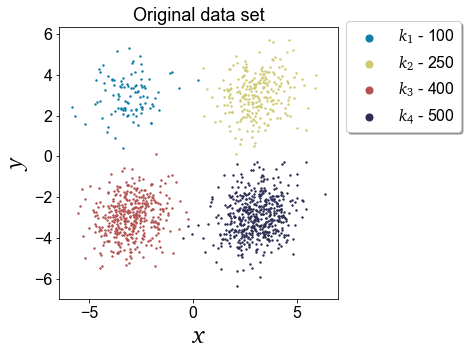

In [5]:
if save_plots: save_filename = '../images/tutorial-train-test-select-original-data-set.svg'
preprocess.plot_2d_clustering(x, y, idx, x_label='$x$', y_label='$y$', color_map=color_map, first_cluster_index_zero=first_cluster, figure_size=figure_size, title='Original data set', save_filename=save_filename)

The only information about the original data set that will be needed is
the vector ``idx`` of cluster classifications.


Note that ``idx_train`` and ``idx_test``, that are the outputs of the sampling functions in this module, have a different interpretation than ``idx``. They are vectors containing
observation indices, *not* cluster classifications.
For instance, if train samples are composed of the first, second and tenth
observation then ``idx_train=[0,1,9]``.

You can find which cluster each observation in ``idx_train`` (or ``idx_test``)
belongs to, for instance through:

```python
idx[idx_train,]
idx[idx_test,]
```

You can also extract a subset of ``idx_train`` that are only the indices belonging to a
particular cluster.
For instance, for the first cluster you can extract them by:

```python
train_indices_in_cluster_1 = [i for i in idx_train if idx[i,]==0]
```

for the second cluster:

```python
train_indices_in_cluster_2 = [i for i in idx_train if idx[i,]==1]
```

and so on.

We start by initalizing an object of the ``DataSampler`` class. For the moment,
we will set the parameter ``idx_test`` to an empty list, but we will demonstrate
an example for setting that parameter to something else later. Note that we can
set a fixed random seed if we want the sampling results to be reproducible. With
``verbose=True``, we will additionally see some detailed information about the current
sampling.

In [7]:
sample = DataSampler(idx, idx_test=None, random_seed=random_seed, verbose=True)

***
<a id='select_fixed_number'></a>
## Sample a fixed number

[**↑ Go to the top**](#top-page)

We first select a fixed number of samples using the ``DataSampler.number``
function. Let's request 15% of the total data to be the train data. The function
calculates that it needs to select 46 samples from each cluster, which
amounts to 14.7% of the total number of samples in the data set. Whenever the exact percentage
requested by the user cannot be achieved, the function always under-samples.

<img src="../images/sampling-test-selection-option-number.svg" style="height:200px">

### Select test data with ``test_selection_option=1``

There are always two ways in which the complementary test data can be selected.
They can be selected using the ``test_selection_option`` parameter.
We start with ``test_selection_option=1``, which selects all remaining
observations as the test data:

In [8]:
(idx_train, idx_test) = sample.number(15, test_selection_option=1)

Cluster 0: taking 46 train samples out of 100 observations (46.0%).
Cluster 1: taking 46 train samples out of 250 observations (18.4%).
Cluster 2: taking 46 train samples out of 400 observations (11.5%).
Cluster 3: taking 46 train samples out of 500 observations (9.2%).

Cluster 0: taking 54 test samples out of 54 remaining observations (100.0%).
Cluster 1: taking 204 test samples out of 204 remaining observations (100.0%).
Cluster 2: taking 354 test samples out of 354 remaining observations (100.0%).
Cluster 3: taking 454 test samples out of 454 remaining observations (100.0%).

Selected 184 train samples (14.7%) and 1066 test samples (85.3%).



A dedicated plotting function from the ``preprocess`` module can be used to visualize
the train and test samples. This function takes as inputs the obtained ``idx_train``
and ``idx_test`` vectors. Note that a custom colormap can be specified by the user.

The visual result of this sampling can be seen below:

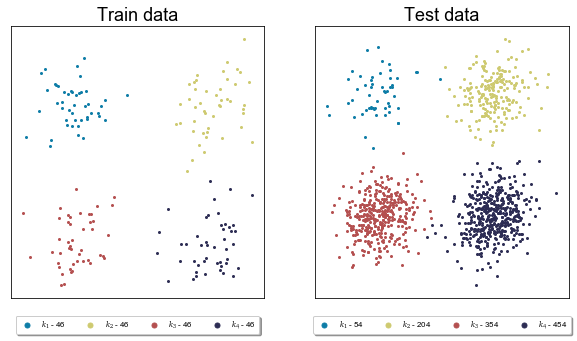

In [9]:
if save_plots: save_filename = '../images/tutorial-train-test-select-fixed-number-1.svg'
plt = preprocess.plot_2d_train_test_samples(x, y, idx, idx_train, idx_test, color_map=color_map, first_cluster_index_zero=first_cluster, figure_size=(10,5), save_filename=save_filename)

### Select test data with ``test_selection_option=2``

We then set ``test_selection_option=2`` which selects a fixed number of
test samples from each cluster, calculated based on the smallest cluster. This
amounts to 54 test samples from each cluster.

In [12]:
(idx_train, idx_test) = sample.number(15, test_selection_option=2)

Cluster 0: taking 46 train samples out of 100 observations (46.0%).
Cluster 1: taking 46 train samples out of 250 observations (18.4%).
Cluster 2: taking 46 train samples out of 400 observations (11.5%).
Cluster 3: taking 46 train samples out of 500 observations (9.2%).

Cluster 0: taking 54 test samples out of 54 remaining observations (100.0%).
Cluster 1: taking 54 test samples out of 204 remaining observations (26.5%).
Cluster 2: taking 54 test samples out of 354 remaining observations (15.3%).
Cluster 3: taking 54 test samples out of 454 remaining observations (11.9%).

Selected 184 train samples (14.7%) and 216 test samples (17.3%).



The visual result of this sampling can be seen below:

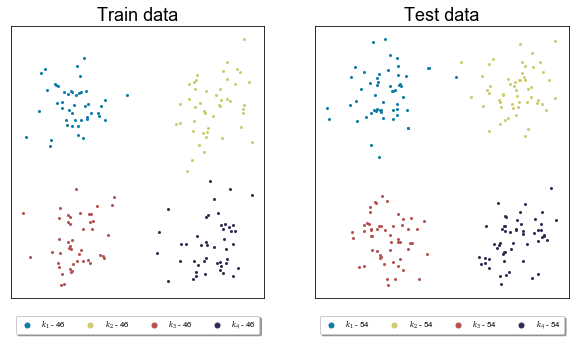

In [13]:
if save_plots: save_filename = '../images/tutorial-train-test-select-fixed-number-2.svg'
plt = preprocess.plot_2d_train_test_samples(x, y, idx, idx_train, idx_test, color_map=color_map, first_cluster_index_zero=first_cluster, figure_size=(10,5), save_filename=save_filename)

***
<a id='select_fixed_percentage'></a>
## Sample a fixed percentage

[**↑ Go to the top**](#top-page)

Next, we select a percentage of samples from each cluster using the
``DataSampler.percentage`` function. Let's request 10% of the total data to be the train
data - the function selects 10% of samples from each cluster.

<img src="../images/sampling-test-selection-option-percentage.svg" style="height:200px">

### Select test data with ``test_selection_option=1``

We start with ``test_selection_option=1``, which selects all remaining
observations as the test data:

In [14]:
(idx_train, idx_test) = sample.percentage(10, test_selection_option=1)

Cluster 0: taking 10 train samples out of 100 observations (10.0%).
Cluster 1: taking 25 train samples out of 250 observations (10.0%).
Cluster 2: taking 40 train samples out of 400 observations (10.0%).
Cluster 3: taking 50 train samples out of 500 observations (10.0%).

Cluster 0: taking 90 test samples out of 90 remaining observations (100.0%).
Cluster 1: taking 225 test samples out of 225 remaining observations (100.0%).
Cluster 2: taking 360 test samples out of 360 remaining observations (100.0%).
Cluster 3: taking 450 test samples out of 450 remaining observations (100.0%).

Selected 125 train samples (10.0%) and 1125 test samples (90.0%).



The visual result of this sampling can be seen below:

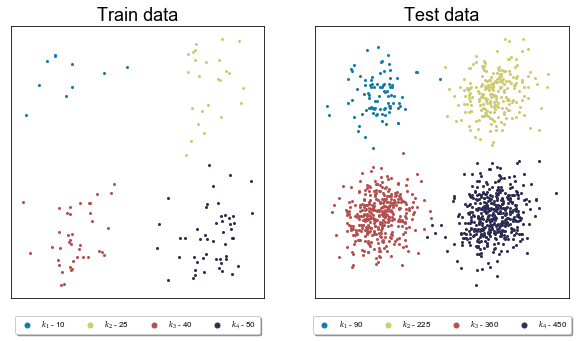

In [15]:
if save_plots: save_filename = '../images/tutorial-train-test-select-fixed-percentage-1.svg'
plt = preprocess.plot_2d_train_test_samples(x, y, idx, idx_train, idx_test, color_map=color_map, first_cluster_index_zero=first_cluster, figure_size=(10,5), save_filename=save_filename)

### Select test data with ``test_selection_option=2``

We then set ``test_selection_option=2`` which uses the same procedure
to select the test data as was used to select the train data. In this case,
it also selects 10% of samples from each cluster as the test samples.


In [16]:
(idx_train, idx_test) = sample.percentage(10, test_selection_option=2)

Cluster 0: taking 10 train samples out of 100 observations (10.0%).
Cluster 1: taking 25 train samples out of 250 observations (10.0%).
Cluster 2: taking 40 train samples out of 400 observations (10.0%).
Cluster 3: taking 50 train samples out of 500 observations (10.0%).

Cluster 0: taking 10 test samples out of 90 remaining observations (11.1%).
Cluster 1: taking 25 test samples out of 225 remaining observations (11.1%).
Cluster 2: taking 40 test samples out of 360 remaining observations (11.1%).
Cluster 3: taking 50 test samples out of 450 remaining observations (11.1%).

Selected 125 train samples (10.0%) and 125 test samples (10.0%).



The visual result of this sampling can be seen below:

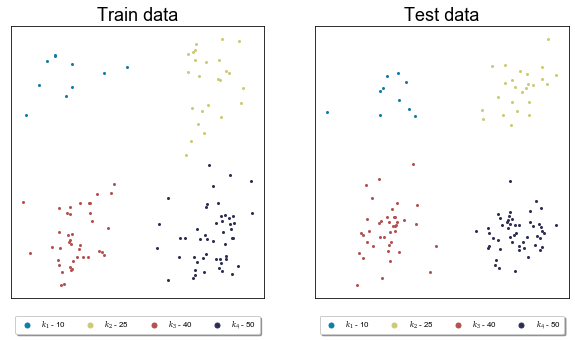

In [17]:
if save_plots: save_filename = '../images/tutorial-train-test-select-fixed-percentage-2.svg'
plt = preprocess.plot_2d_train_test_samples(x, y, idx, idx_train, idx_test, color_map=color_map, first_cluster_index_zero=first_cluster, figure_size=(10,5), save_filename=save_filename)

***
<a id='select_manually'></a>
## Sample manually

[**↑ Go to the top**](#top-page)

We select samples manually from each cluster using the ``DataSampler.manual``
function.

<img src="../images/sampling-test-selection-option-manual.svg" style="height:200px">

### Select test data with ``test_selection_option=1``

We start with ``test_selection_option=1`` which selects all remaining
observations as the test data.
Let's request 4, 5, 10 and 2 samples from the first, second, third and fourth cluster respectively.
The sampling dictionary will thus have to be:
``sampling_dictionary={0:4, 1:5, 2:10, 3:2}``. Note that the function
still selects those samples randomly from each cluster.
We should also change ``sampling_type`` to ``'number'`` so that samples are
selected on a number and not a percentage basis:

In [18]:
(idx_train, idx_test) = sample.manual({0:4, 1:5, 2:10, 3:2}, sampling_type='number', test_selection_option=1)

Cluster 0: taking 4 train samples out of 100 observations (4.0%).
Cluster 1: taking 5 train samples out of 250 observations (2.0%).
Cluster 2: taking 10 train samples out of 400 observations (2.5%).
Cluster 3: taking 2 train samples out of 500 observations (0.4%).

Cluster 0: taking 96 test samples out of 96 remaining observations (100.0%).
Cluster 1: taking 245 test samples out of 245 remaining observations (100.0%).
Cluster 2: taking 390 test samples out of 390 remaining observations (100.0%).
Cluster 3: taking 498 test samples out of 498 remaining observations (100.0%).

Selected 21 train samples (1.7%) and 1229 test samples (98.3%).



The visual result of this sampling can be seen below:

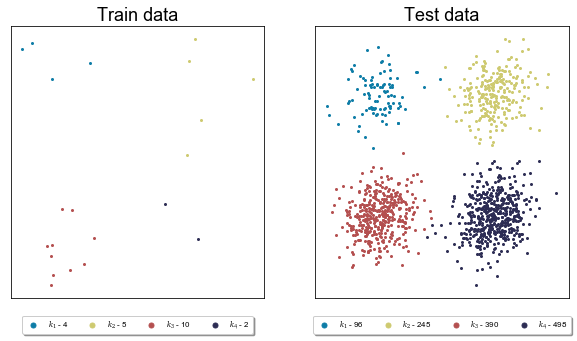

In [19]:
if save_plots: save_filename = '../images/tutorial-train-test-select-manually-1.svg'
plt = preprocess.plot_2d_train_test_samples(x, y, idx, idx_train, idx_test, color_map=color_map, first_cluster_index_zero=first_cluster, figure_size=(10,5), save_filename=save_filename)

### Select test data with ``test_selection_option=2``

We then set ``test_selection_option=2`` which uses the same procedure
to select the test data as was used to select the train data. This time, let's request
50%, 10%, 10% and 20% from the first, second, third and fourth cluster respectively.
The sampling dictionary will thus have to be:
``sampling_dictionary={0:50, 1:10, 2:10, 3:20}`` and we should change the
``sampling_type`` to ``'percentage'``:

In [20]:
(idx_train, idx_test) = sample.manual({0:50, 1:10, 2:10, 3:20}, sampling_type='percentage', test_selection_option=2)

Cluster 0: taking 50 train samples out of 100 observations (50.0%).
Cluster 1: taking 25 train samples out of 250 observations (10.0%).
Cluster 2: taking 40 train samples out of 400 observations (10.0%).
Cluster 3: taking 100 train samples out of 500 observations (20.0%).

Cluster 0: taking 50 test samples out of 50 remaining observations (100.0%).
Cluster 1: taking 25 test samples out of 225 remaining observations (11.1%).
Cluster 2: taking 40 test samples out of 360 remaining observations (11.1%).
Cluster 3: taking 100 test samples out of 400 remaining observations (25.0%).

Selected 215 train samples (17.2%) and 215 test samples (17.2%).



The visual result of this sampling can be seen below:

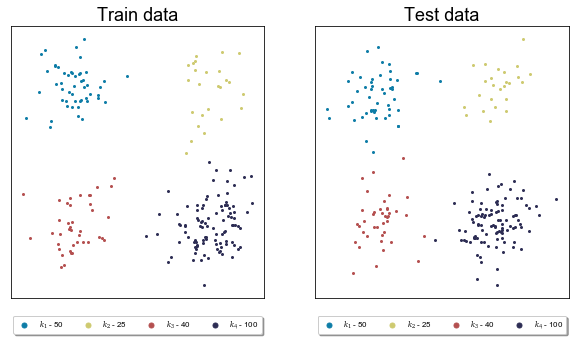

In [21]:
if save_plots: save_filename = '../images/tutorial-train-test-select-manually-2.svg'
plt = preprocess.plot_2d_train_test_samples(x, y, idx, idx_train, idx_test, color_map=color_map, first_cluster_index_zero=first_cluster, figure_size=(10,5), save_filename=save_filename)

***
<a id='select_at_random'></a>
## Sample at random

[**↑ Go to the top**](#top-page)

Finally, we select random samples using the ``DataSampler.random`` function.
Let's request 10% of the total data to be the train data.

Note, that random sampling will typically give a very similar sample distribution as
percentage sampling. The only difference is that percentage sampling will
maintain the percentage ``perc`` exact within each cluster while random sampling
will typically result in some small variations from ``perc`` in each cluster
since it is sampling independently of cluster definitions.

<img src="../images/sampling-test-selection-option-random.svg" style="height:200px">

### Select test data with ``test_selection_option=1``

We start with ``test_selection_option=1`` which selects all remaining
observations as test data.

In [22]:
(idx_train, idx_test) = sample.random(10, test_selection_option=1)

Cluster 0: taking 14 train samples out of 100 observations (14.0%).
Cluster 1: taking 28 train samples out of 250 observations (11.2%).
Cluster 2: taking 42 train samples out of 400 observations (10.5%).
Cluster 3: taking 41 train samples out of 500 observations (8.2%).

Cluster 0: taking 86 test samples out of 86 remaining observations (100.0%).
Cluster 1: taking 222 test samples out of 222 remaining observations (100.0%).
Cluster 2: taking 358 test samples out of 358 remaining observations (100.0%).
Cluster 3: taking 459 test samples out of 459 remaining observations (100.0%).

Selected 125 train samples (10.0%) and 1125 test samples (90.0%).



The visual result of this sampling can be seen below:

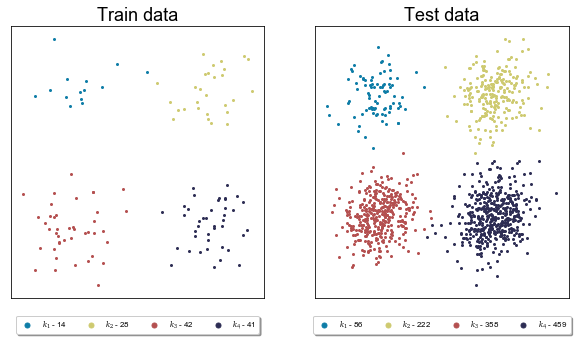

In [23]:
if save_plots: save_filename = '../images/tutorial-train-test-select-random-doc-1.svg'
plt = preprocess.plot_2d_train_test_samples(x, y, idx, idx_train, idx_test, color_map=color_map, first_cluster_index_zero=first_cluster, figure_size=(10,5),save_filename=save_filename)

### Select test data with ``test_selection_option=2``

We then set ``test_selection_option=2`` which uses the same procedure
to select the test data as was used to select the train data. In this case, it will also sample
10% of the total data set as the test data.

In [24]:
(idx_train, idx_test) = sample.random(10, test_selection_option=2)

Cluster 0: taking 14 train samples out of 100 observations (14.0%).
Cluster 1: taking 28 train samples out of 250 observations (11.2%).
Cluster 2: taking 42 train samples out of 400 observations (10.5%).
Cluster 3: taking 41 train samples out of 500 observations (8.2%).

Cluster 0: taking 8 test samples out of 86 remaining observations (9.3%).
Cluster 1: taking 25 test samples out of 222 remaining observations (11.3%).
Cluster 2: taking 29 test samples out of 358 remaining observations (8.1%).
Cluster 3: taking 63 test samples out of 459 remaining observations (13.7%).

Selected 125 train samples (10.0%) and 125 test samples (10.0%).



The visual result of this sampling can be seen below:

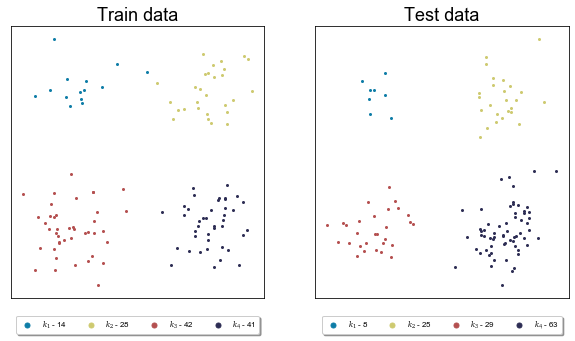

In [25]:
if save_plots: save_filename = '../images/tutorial-train-test-select-random-doc-2.svg'
plt = preprocess.plot_2d_train_test_samples(x, y, idx, idx_train, idx_test, color_map=color_map, first_cluster_index_zero=first_cluster, figure_size=(10,5), save_filename=save_filename)

***
<a id='maintain_fixed_test_data'></a>
## Maintaining a fixed test data set

[**↑ Go to the top**](#top-page)

In this example, we further illustrate how maintaining a fixed test data set
functionality can be utilized.
Suppose that in every cluster you have a very distinct set of observations on
which you always want to test your model.
You can point out those observations when initializing a ``DataSampler``
object through the use of the ``idx_test`` parameter.

We simulate this situation by appending additional samples to the previously
defined data set. We add 20 samples in each cluster - those sammples can be seen in the
figure below as smaller clouds next to each cluster:

In [26]:
Nt_1, Nt_2, Nt_3, Nt_4 = 20, 20, 20, 20
mean_k1, mean_k2, mean_k3, mean_k4 = [-7, 7], [7, 7], [-7, -7], [7, -7]
covariance = [[0.2, .1], [.1, 0.2]]
xt_k1, yt_k1 = np.random.multivariate_normal(mean_k1, covariance, Nt_1).T
xt_k2, yt_k2 = np.random.multivariate_normal(mean_k2, covariance, Nt_2).T
xt_k3, yt_k3 = np.random.multivariate_normal(mean_k3, covariance, Nt_3).T
xt_k4, yt_k4 = np.random.multivariate_normal(mean_k4, covariance, Nt_4).T
xt = np.vstack((xt_k1[:,np.newaxis], xt_k2[:,np.newaxis], xt_k3[:,np.newaxis], xt_k4[:,np.newaxis], x))
yt = np.vstack((yt_k1[:,np.newaxis], yt_k2[:,np.newaxis], yt_k3[:,np.newaxis], yt_k4[:,np.newaxis], y))
idx_appended = np.vstack((np.zeros((Nt_1, 1)), np.ones((Nt_2, 1)), 2*np.ones((Nt_3, 1)), 3*np.ones((Nt_4, 1)), np.zeros((N_1, 1)), np.ones((N_2, 1)), 2*np.ones((N_3, 1)), 3*np.ones((N_4, 1)))).astype(int).ravel()
idx_test = np.arange(0,Nt_1+Nt_2+Nt_3+Nt_4,1)
populations = preprocess.get_populations(idx_appended)

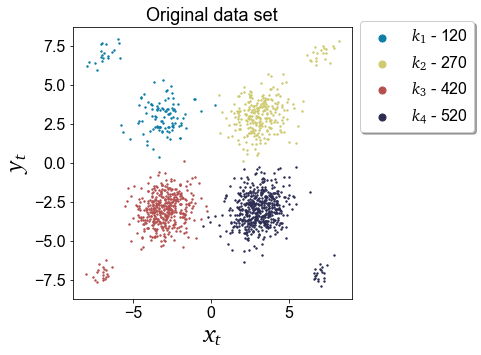

In [27]:
if save_plots: save_filename = '../images/tutorial-train-test-select-original-data-set-appended-doc.svg'
plt = preprocess.plot_2d_clustering(xt, yt, idx_appended, x_label="$x_t$", y_label="$y_t$", color_map=color_map, first_cluster_index_zero=first_cluster, figure_size=figure_size, title='Original data set', save_filename=save_filename)

Assuming that we know the indices of points that represent the appended clouds, stored in
``idx_test``, we can use that array of indices as an input parameter:

In [28]:
sample = DataSampler(idx_appended, idx_test=idx_test, random_seed=random_seed, verbose=True)

User defined test samples will be used. Parameter `test_selection_option` will be ignored.



Any sampling function now called will maintain those samples as the test data and the
train data will be sampled ignoring the indices in ``idx_test``.
Note also that if ``idx_test`` is specified, the ``test_selection_option`` parameter is ignored.

We will demonstrate this sampling using the ``DataSampler.random`` function, but
any other sampling function that we demonstrated earlier can be used as well.

In [29]:
(idx_train, idx_test) = sample.random(80, test_selection_option=2)

Cluster 0: taking 86 train samples out of 120 observations (71.7%).
Cluster 1: taking 211 train samples out of 270 observations (78.1%).
Cluster 2: taking 347 train samples out of 420 observations (82.6%).
Cluster 3: taking 420 train samples out of 520 observations (80.8%).

Cluster 0: taking 20 test samples out of 34 remaining observations (58.8%).
Cluster 1: taking 20 test samples out of 59 remaining observations (33.9%).
Cluster 2: taking 20 test samples out of 73 remaining observations (27.4%).
Cluster 3: taking 20 test samples out of 100 remaining observations (20.0%).

Selected 1064 train samples (80.0%) and 80 test samples (6.0%).



The visual result of this sampling can be seen below:

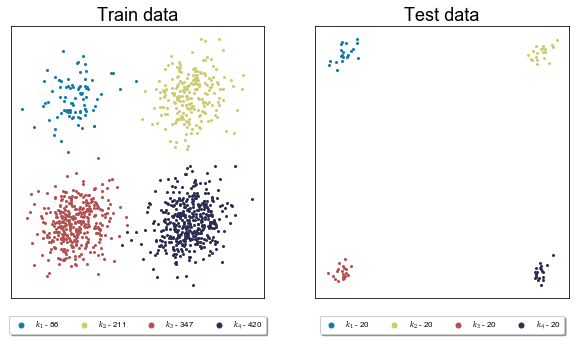

In [30]:
if save_plots: save_filename = '../images/tutorial-train-test-select-random-with-idx-test-doc.svg'
plt = preprocess.plot_2d_train_test_samples(xt, yt, idx_appended, idx_train, idx_test, color_map=color_map, first_cluster_index_zero=first_cluster, figure_size=(10,5), save_filename=save_filename)

***
<a id='chaining_sampling_functions'></a>
## Chaining sampling functions

[**↑ Go to the top**](#top-page)

Finally, we discuss an interesting use-case for chaining two sampling
functions, where train samples obtained from one sampling can become a fixed test
data for another sampling.

Suppose that our target is to have a fixed test data set composed of:

- 10 samples from the first cluster
- 20 samples from the second cluster
- 10 samples from the third cluster
- 50 samples from the fourth cluster

and, at the same time, select a fixed number of train samples from each cluster.

We can start with generating the desired test samples using the
``DataSampler.manual`` function. We can output the train data as the test data:

In [31]:
sample = DataSampler(idx, random_seed=random_seed, verbose=True)
(idx_test, _) = sample.manual({0:10, 1:20, 2:10, 3:50}, sampling_type='number', test_selection_option=1)

Cluster 0: taking 10 train samples out of 100 observations (10.0%).
Cluster 1: taking 20 train samples out of 250 observations (8.0%).
Cluster 2: taking 10 train samples out of 400 observations (2.5%).
Cluster 3: taking 50 train samples out of 500 observations (10.0%).

Cluster 0: taking 90 test samples out of 90 remaining observations (100.0%).
Cluster 1: taking 230 test samples out of 230 remaining observations (100.0%).
Cluster 2: taking 390 test samples out of 390 remaining observations (100.0%).
Cluster 3: taking 450 test samples out of 450 remaining observations (100.0%).

Selected 90 train samples (7.2%) and 1160 test samples (92.8%).



Now we feed the obtained test set as a fixed test set for the target sampling:

In [32]:
sample.idx_test = idx_test
(idx_train, idx_test) = sample.number(19.5, test_selection_option=1)

User defined test samples will be used. Parameter `test_selection_option` will be ignored.

Cluster 0: taking 60 train samples out of 100 observations (60.0%).
Cluster 1: taking 60 train samples out of 250 observations (24.0%).
Cluster 2: taking 60 train samples out of 400 observations (15.0%).
Cluster 3: taking 60 train samples out of 500 observations (12.0%).

Cluster 0: taking 10 test samples out of 40 remaining observations (25.0%).
Cluster 1: taking 20 test samples out of 190 remaining observations (10.5%).
Cluster 2: taking 10 test samples out of 340 remaining observations (2.9%).
Cluster 3: taking 50 test samples out of 440 remaining observations (11.4%).

Selected 240 train samples (19.2%) and 90 test samples (7.2%).



The visual result of this sampling can be seen below:

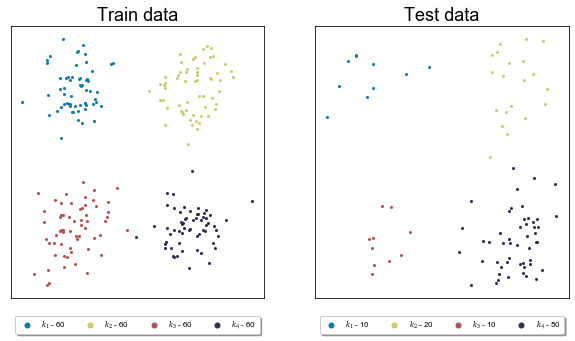

In [33]:
if save_plots: save_filename = '../images/tutorial-train-test-select-chaining-functions.svg'
plt = preprocess.plot_2d_train_test_samples(x, y, idx, idx_train, idx_test, color_map=color_map, first_cluster_index_zero=first_cluster, figure_size=(10,5), save_filename=save_filename)

Notice that we have achieved what we wanted to: we generated a desired test
data set with 10, 20, 10 and 50 samples, and we also have an equal number of
train samples selected from each cluster - in this case 60 samples.

***